# Remoção de ruídos de documentos utilizando Auto Encoder Convolucional

### Arquivos e Imports necessários

In [0]:
# Fetch files into GOOGLE COLAB

# !git clone https://github.com/talesaraujo/autoencoder-image-denoising.git && mv autoencoder-image-denoising/kdd kdd/
# !rm -rf autoencoder*

!ls -la

In [2]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from keras.callbacks import TensorBoard
from keras.utils import plot_model

import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.transform import resize,rescale
from os import listdir

from IPython.display import Image

Using TensorFlow backend.


### Carregamento e montagem dos dados em memória para realizar o treinamento

Como nossos dados são imagens salvas no disco, precisamos de uma função customizada

In [0]:
# Set images fixed sizes
IMG_LENGTH, IMG_WIDTH = (540, 260)

dir_list = ['kdd/train/', 'kdd/train_cleaned/', 'kdd/test/']

def get_sample_set(directory, sizes):
	sample_set = []

	for file in listdir(directory):
		img = imread(directory + file)
		img = resize(img, sizes, True)
		img = img.reshape(1, img.shape[0], img.shape[1])
		sample_set.append(img)

	sample_set = tuple(sample_set)
	sample_set = np.concatenate(sample_set)

	return sample_set


sample_sets = [get_sample_set(dir_list[i], (IMG_WIDTH, IMG_LENGTH)) for i in range(0, 3)]

x_train, y_train, x_test = (sample_sets[0], sample_sets[1], sample_sets[2])

In [4]:
x_train.shape, y_train.shape, x_test.shape

((144, 260, 540), (144, 260, 540), (72, 260, 540))

### Preparando os tensores

In [5]:
x_train = np.reshape(x_train, (len(x_train), IMG_WIDTH, IMG_LENGTH, 1))  # Adapt this if using `channels_first` image data format

y_train = np.reshape(y_train, (len(x_train), IMG_WIDTH, IMG_LENGTH, 1))  # Adapt this if using `channels_first` image data format

x_test = np.reshape(x_test, (len(x_test), IMG_WIDTH, IMG_LENGTH, 1))  # Adapt this if using `channels_first` image data format


x_train.shape, y_train.shape, x_test.shape

((144, 260, 540, 1), (144, 260, 540, 1), (72, 260, 540, 1))

### Treino, Validação e Teste 

Agora que temos os tensores preparados, vamos fazer a separação dos tensores em treino e validação

In [0]:
x_train, x_validation = (x_train[0:120], x_train[120:144])
y_train, y_validation = (y_train[0:120], y_train[120:144])

In [9]:
x_train.shape

(120, 260, 540, 1)

### Encoder

Um modelo de Auto Encoder é composto por duas partes principais, o encoder e o decoder

O encoder recebe os dados de entrada e os leva para outro espaço dimensional, no nosso caso esse espaço é maior que o espaço original dos atributos

W0616 02:23:22.429027 140388590188416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0616 02:23:22.470106 140388590188416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0616 02:23:22.495888 140388590188416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



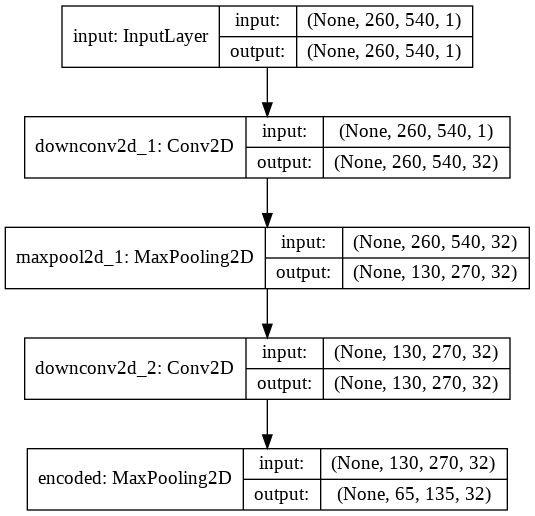

In [10]:
input_img = Input(shape=(IMG_WIDTH, IMG_LENGTH, 1), name='input')

downConv = Conv2D(32, (3,3), activation='relu', padding='same', name='downconv2d_1')(input_img)
downConv = MaxPooling2D((2,2), padding='same', name='maxpool2d_1')(downConv)
downConv = Conv2D(32, (3,3), activation='relu', padding='same', name='downconv2d_2')(downConv)
encoded = MaxPooling2D((2,2), padding='same', name='encoded')(downConv)

encoder = Model(input_img, encoded, name='encoder')


plot_model(encoder, to_file='cae_encoder.png', show_shapes=True)
Image(retina=False, filename='cae_encoder.png', width=535, height=516)

### Decoder

O decoder recebe os dados no novo espaço de atributos, ou seja, o resultado do encoder, e os leva de volta para o espaço original

No caso do nosso Auto Encoder, o resultado final do decoder no espaço de atributos original será a imagem sem ruídos

W0616 02:23:27.783607 140388590188416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2018: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor instead.



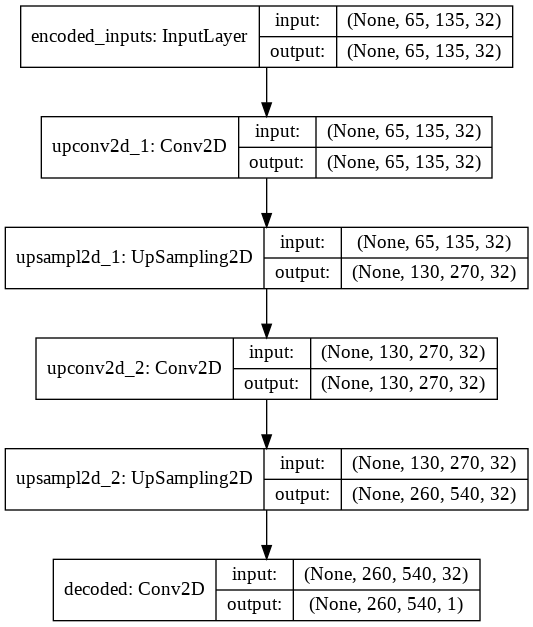

In [11]:
encoded_inputs = Input(shape=(65, 135, 32), name='encoded_inputs')

upConv = Conv2D(32, (3,3), activation='relu',padding='same', name='upconv2d_1')(encoded_inputs)
upConv = UpSampling2D((2,2), name='upsampl2d_1')(upConv)
upConv = Conv2D(32, (3,3), activation='relu', padding='same', name='upconv2d_2')(upConv)
upConv = UpSampling2D((2,2), name='upsampl2d_2')(upConv)
decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='decoded')(upConv)

decoder = Model(encoded_inputs, decoded, name='decoder')


plot_model(decoder, to_file='cae_decoder.png', show_shapes=True)
Image(retina=False, filename='cae_decoder.png', width=535, height=516)

### O Autoencoder

Agora que temos os dois componentes do nosso Auto Encoder, podemos montar o modelo completo

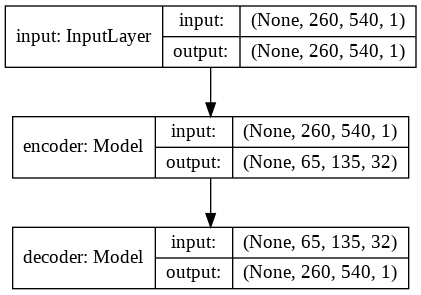

In [12]:
outputs = decoder(encoder(input_img))

autoencoder = Model(input_img, outputs, name='autoencoder')

plot_model(autoencoder, to_file='cae.png', show_shapes=True)

Image(retina=False, filename='cae.png', width=535, height=516)

### O treinamento 

Agora podemos finalmente compilar nosso modelo para realizar o treinamento. 

Iremos utilizar o ADAM como algoritmo de otimizaçao e a entropia cruzada binária como função custo

In [0]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()

history = autoencoder.fit(x_train, y_train,
                                   epochs=100,
                                   batch_size=12,
                                   shuffle=True,
                                   verbose=True,
                                   validation_data=(x_validation, y_validation))

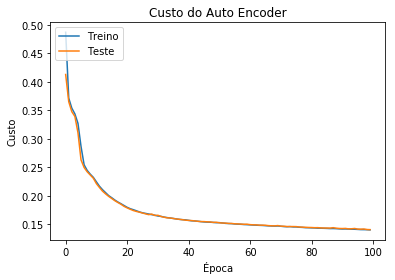

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Custo do Auto Encoder')
plt.ylabel('Custo')
plt.xlabel('Época')
plt.legend(['Treino', 'Teste'], loc='upper left')
plt.show()

Podemos ver que nosso modelo não teve a ocorrência de *overfitting*.

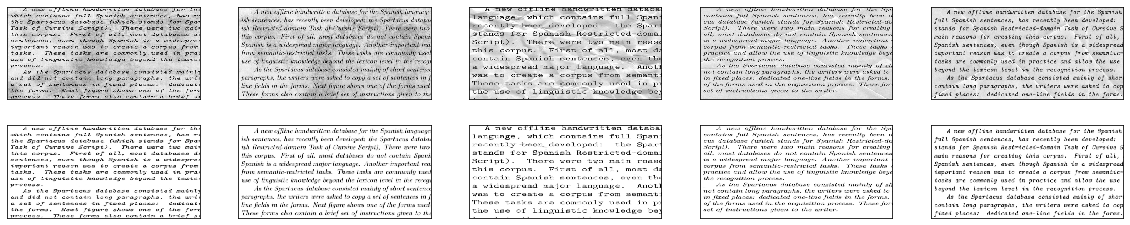

In [15]:
denoised_imgs = autoencoder.predict(x_test)

n = 5
plt.figure(figsize=(20, 4))

for i in range(n):
    # Display the original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(260, 540))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display the reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(denoised_imgs[i].reshape(260, 540))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
#plt.show()
plt.savefig('kdd_result.png')

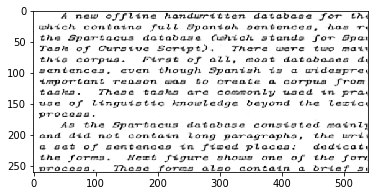

In [16]:
plt.imshow(denoised_imgs[0].reshape(IMG_WIDTH, IMG_LENGTH))

In [0]:
plt.imsave('test.png', x_test[0].reshape(IMG_WIDTH, IMG_LENGTH))
plt.imsave('test_denoised.png', denoised_imgs[0].reshape(IMG_WIDTH, IMG_LENGTH))